#Importando bibliotecas

In [ ]:
import os
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.io import read_image
import torch
from skimage import io
import random
import torchvision.transforms as T
import cv2
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms, models
from torchvision.transforms import Compose, Normalize, ToTensor


#Conexao com o Kaggle

In [ ]:
!pip install kaggle

from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

!unzip chest-xray-pneumonia.zip

#Transformando os dados em csv

In [ ]:
import os
import csv

def criar_csv(diretorio_raiz, pasta):
    caminho_pasta = os.path.join(diretorio_raiz, pasta)
    dados = []

    for classe in os.listdir(caminho_pasta):
        caminho_classe = os.path.join(caminho_pasta, classe)
        if os.path.isdir(caminho_classe):  # Verifica se é um diretório
            for nome_arquivo in os.listdir(caminho_classe):
                if nome_arquivo != '.DS_Store':  # Ignora o arquivo .DS_Store
                    dados.append((nome_arquivo, classe))

    nome_arquivo_csv = f'dados_{pasta}.csv'

    with open(nome_arquivo_csv, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['nome_da_imagem', 'Classe'])
        writer.writerows(dados)

    print(f'Arquivo CSV "{nome_arquivo_csv}" criado com sucesso!')

diretorio_raiz = '/content/chest_xray/chest_xray'
pastas = ['train', 'test','val']

for pasta in pastas:
    criar_csv(diretorio_raiz, pasta)



Arquivo CSV "dados_train.csv" criado com sucesso!
Arquivo CSV "dados_test.csv" criado com sucesso!
Arquivo CSV "dados_val.csv" criado com sucesso!


#Transformando dados em dataframe

                nome_da_imagem  Classe
1220  person368_virus_748.jpeg       1


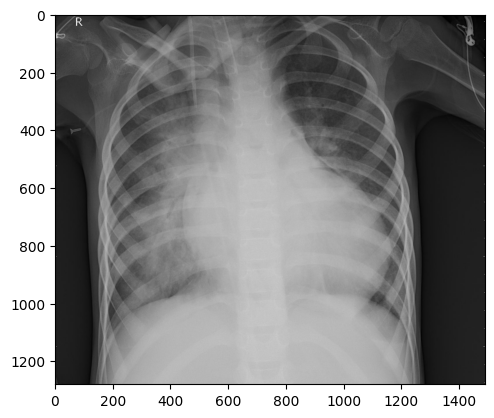

In [ ]:
Train_data = pd.read_csv('/content/dados_train.csv')
Test_data = pd.read_csv('/content/dados_test.csv')
Val_data = pd.read_csv('/content/dados_val.csv')

data = [Train_data,Test_data,Val_data]

issue = {'NORMAL':0, 'PNEUMONIA':1}

#substituindo para valor
for classes in data:
  classes['Classe'] = classes['Classe'].map(issue)

Train_data['nome_da_imagem']


#Testando a imagem
resultado = Train_data[Train_data['nome_da_imagem'] == 'person368_virus_748.jpeg']

print(resultado)

img = cv2.imread('/content/chest_xray/chest_xray/train/PNEUMONIA/person1003_bacteria_2934.jpeg')

# Check if the image was loaded correctly
if img is None:
    print("Error: Image not loaded. Check the image path.")
else:
    # Convert the image from BGR to RGB before displaying with Matplotlib
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()

#Configurando Dataloader para o pythorch



In [ ]:
import os
from PIL import Image


class XrayPneumonia(Dataset):
    def __init__(self, annotations_file_Dataframe, img_dirs, transform=None, target_transform=None):
        self.img_labels = annotations_file_Dataframe
        self.img_dirs = img_dirs
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        for img_dir in self.img_dirs:
            img_path = os.path.join(img_dir, self.img_labels.iloc[idx, 0])
            if os.path.exists(img_path):
                image = Image.open(img_path).convert("RGB")
                label = self.img_labels.iloc[idx, 1]
                if self.transform:
                    image = self.transform(image)
                if self.target_transform:
                    label = self.target_transform(label)
                return image, label




#Criando os dataloaders

In [ ]:
from torch.utils.data import DataLoader
from torchvision import transforms

# Definir o tamanho fixo para as imagens
fixed_size = (256, 256)  # Por exemplo, 224x224 pixels

# Definir transformações para redimensionar as imagens
transform = transforms.Compose([
    transforms.Resize(fixed_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor()
])

# Aplicar transformações aos conjuntos de dados
train_data = XrayPneumonia(Train_data, ['/content/chest_xray/chest_xray/train/NORMAL','/content/chest_xray/chest_xray/train/PNEUMONIA'], transform=transform)
test_data = XrayPneumonia(Test_data,  ['/content/chest_xray/chest_xray/test/NORMAL','/content/chest_xray/chest_xray/test/PNEUMONIA'], transform=transform)
val_data = XrayPneumonia(Val_data,  ['/content/chest_xray/chest_xray/val/NORMAL','/content/chest_xray/chest_xray/val/PNEUMONIA'], transform=transform)


# Criar os DataLoader com os conjuntos de dados transformados
dataloaders = {
    'train': DataLoader(train_data, batch_size=4, shuffle=True, num_workers=2),
    'test': DataLoader(test_data, batch_size=4, shuffle=True, num_workers=2)
}

# Tamanhos dos conjuntos de dados
dataset_sizes = {
    'train': len(train_data),
    'test': len(test_data)
}


#Congelando as camadas para Transfer Learning
#Aproveita os pesos presentes nas camadas iniciais da rede pré-treinada

In [ ]:
model = models.resnet18(pretrained=True) #Carrega um modelo pré-treinado

for name, param in model.named_parameters():
    if "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # Use all parameters


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 184MB/s]


#Treinando a Rede

In [ ]:

num_epochs = 10
for epoch in range(num_epochs):
    for phase in ['train', 'test']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

print("Training complete!")

train Loss: 0.4629 Acc: 0.8298
test Loss: 0.4603 Acc: 0.8365
train Loss: 0.3553 Acc: 0.8589
test Loss: 0.4756 Acc: 0.8253
train Loss: 0.3689 Acc: 0.8522
test Loss: 0.5637 Acc: 0.8141
train Loss: 0.3319 Acc: 0.8708
test Loss: 0.7301 Acc: 0.7628
train Loss: 0.3424 Acc: 0.8669
test Loss: 0.3441 Acc: 0.8926
train Loss: 0.3527 Acc: 0.8696
test Loss: 0.6924 Acc: 0.7804
train Loss: 0.3381 Acc: 0.8700
test Loss: 0.4121 Acc: 0.8542
train Loss: 0.3563 Acc: 0.8639
test Loss: 0.4283 Acc: 0.8349
train Loss: 0.3461 Acc: 0.8685
test Loss: 0.4416 Acc: 0.8381
train Loss: 0.3360 Acc: 0.8735
test Loss: 0.7396 Acc: 0.7724
Training complete!


#Testando o modelo com uma imagem não vista

In [ ]:
# Save the model
torch.save(model.state_dict(), 'IdentifyPneumonia.pth')

In [ ]:
import torch
from torchvision import models, transforms
from PIL import Image

# Load the saved model
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1000)  # Adjust to match the original model's output units
model.load_state_dict(torch.load('IdentifyPneumonia.pth'))
model.eval()

# Create a new model with the correct final layer
new_model = models.resnet18(pretrained=True)
new_model.fc = nn.Linear(new_model.fc.in_features, 2)  # Adjust to match the desired output units

# Copy the weights and biases from the loaded model to the new model
new_model.fc.weight.data = model.fc.weight.data[0:2]  # Copy only the first 2 output units
new_model.fc.bias.data = model.fc.bias.data[0:2]

In [ ]:
# Load and preprocess the unseen image
image_path = '/content/chest_xray/chest_xray/val/PNEUMONIA/person1949_bacteria_4880.jpeg'  # Replace with the path to your image
image = Image.open(image_path).convert('L')
image = image.convert('RGB')
fixed_size = (256, 256)  # Por exemplo, 224x224 pixels

# Definir transformações para redimensionar as imagens
transform = transforms.Compose([
    transforms.Resize(fixed_size),
    transforms.ToTensor()  # Converte a imagem para tensor
])

input_tensor = transform(image)
input_batch = input_tensor.unsqueeze(0)  # Add a batch dimension

In [ ]:
# Perform inference
with torch.no_grad():
    output = model(input_batch)

# Get the predicted class
_, predicted_class = output.max(1)

# Map the predicted class to the class name
class_names = [0, 1]  # Make sure these class names match your training data
predicted_class_name = class_names[predicted_class.item()]

map = {
    0: 'NORMAL',
    1: 'PNEUMONIA'
}

print(f'The predicted class is: {map[predicted_class_name]}')

The predicted class is: PNEUMONIA


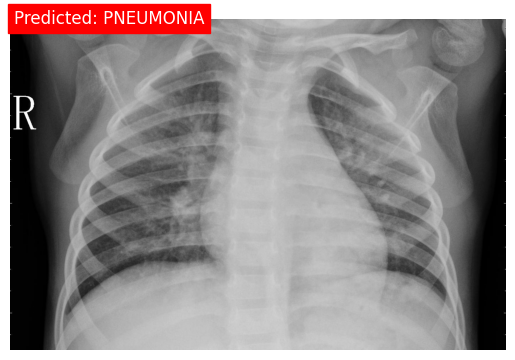

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Display the image with the predicted class name
image = np.array(image)
plt.imshow(image)
plt.axis('off')
plt.text(10, 10, f'Predicted: {map[predicted_class_name]}', fontsize=12, color='white', backgroundcolor='red')
plt.show()

#Matriz de Confusão

In [ ]:

def passa_pela_rede(image_path,model):
  '''
  recebe uma imagem, processa a imagem e o modelo e retorna a classe da imagem
  '''
  image = Image.open(image_path).convert('L')
  image = image.convert('RGB')
  fixed_size = (256, 256)  # Por exemplo, 224x224 pixels

  # Definir transformações para redimensionar as imagens
  transform = transforms.Compose([
      transforms.Resize(fixed_size),
      transforms.ToTensor()  # Converte a imagem para tensor
  ])

  input_tensor = transform(image)
  input_batch = input_tensor.unsqueeze(0)  # Add a batch dimension

    # Perform inference
  with torch.no_grad():
      output = model(input_batch)

  # Get the predicted class
  _, predicted_class = output.max(1)


  # Map the predicted class to the class name
  class_names = [0, 1]  # Make sure these class names match your training data
  predicted_class_name = class_names[predicted_class.item()]

  map = {
      0: 'NORMAL',
      1: 'PNEUMONIA'
  }

  return map[predicted_class_name]



Carregando o modelo pré treinado

In [ ]:
# Load the saved model
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1000)  # Adjust to match the original model's output units
model.load_state_dict(torch.load('IdentifyPneumonia.pth'))
model.eval()

# Create a new model with the correct final layer
new_model = models.resnet18(pretrained=True)
new_model.fc = nn.Linear(new_model.fc.in_features, 2)  # Adjust to match the desired output units

# Copy the weights and biases from the loaded model to the new model
new_model.fc.weight.data = model.fc.weight.data[0:2]  # Copy only the first 2 output units
new_model.fc.bias.data = model.fc.bias.data[0:2]

Criando as listas de previsoes e a verdadeira

In [ ]:
img_dirs = ['/content/chest_xray/chest_xray/val/NORMAL','/content/chest_xray/chest_xray/val/PNEUMONIA']


predict_list = [] #lista das previsoes
true_list = [] #lista das verdadeiras

for img_dir in img_dirs: #le cada diretorio
  for idx in range(len(Val_data)):
    img_path = os.path.join(img_dir, Val_data.iloc[idx, 0]) #cria o image_path

    if os.path.exists(img_path): #verifica se o img path existe
      true_list.append(Val_data.iloc[idx, 1]) #adciona na lista de verdadeiras
      predict = passa_pela_rede(img_path, model) #faz a previsao utilizando o modelo
      predict_num = 1 if predict == 'PNEUMONIA' else 0
      predict_list.append(predict_num) #adciona na lista de predicts

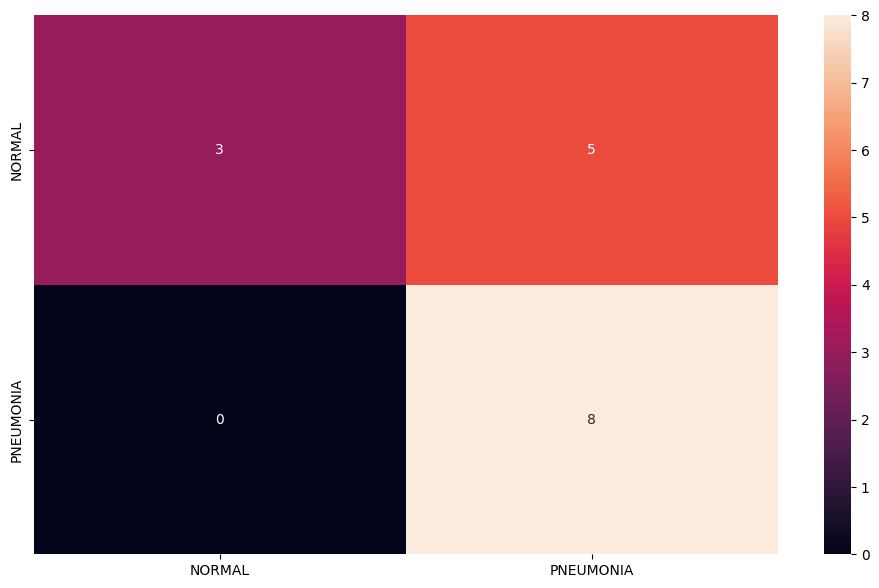

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

classes = ['NORMAL', 'PNEUMONIA']

cf_matrix = confusion_matrix(true_list, predict_list)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
accuracy_score(true_list, predict_list)

0.6875

In [ ]:
print(classification_report(true_list, predict_list))

              precision    recall  f1-score   support

           0       1.00      0.38      0.55         8
           1       0.62      1.00      0.76         8

    accuracy                           0.69        16
   macro avg       0.81      0.69      0.65        16
weighted avg       0.81      0.69      0.65        16



#Conclusao

O modelo acerta de maneira interessante quando a imagem se trata de PNEUMONIA, logo quando é dado que é pneumonia há uma grande probabilidade de ser de fato PNEUMONIA. Porém quando é um pulmão nomal o modelo obteve apensa 0.38 de recall,logo um pulmão com pneumonia pode ser classificado como um pulmão normal. O que é de fato ruim

In [ ]:
def imprime_torchimg(image,label):
  image = image.permute(1, 2, 0)
  image = np.array(image)
  plt.imshow(image)
  plt.axis('off')
  plt.text(10, 10, f'Predicted: {label}', fontsize=12, color='white', backgroundcolor='red')
  plt.show()

y_pred = []
y_true = []

map = {
    0: 'NORMAL',
    1: 'PNEUMONIA'
}
